# https://d2l.ai/chapter_multilayer-perceptrons/weight-decay.html

In [3]:
%matplotlib inline
import torch as tc
import tensorflow as tf
import mxnet as mx
from mxnet import np as mxnp
from mxnet import npx as npx
npx.set_np()
import numpy as np

from d2l import mxnet as mxd2l  # Use MXNet as the backend
from d2l import torch as tcd2l  # Use PyTorch as the backend
from d2l import tensorflow as tfd2l  # Use TensorFlow as the backend

from d2l import mxnet as mxd2l  # Use MXNet as the backend
from d2l import torch as tcd2l  # Use PyTorch as the backend
from d2l import tensorflow as tfd2l  # Use TensorFlow as the backend

tc.__version__,tf.__version__,mx.__version__

('1.6.0', '2.3.1', '1.7.0')

## mxnet_scratch

In [2]:
from mxnet import autograd, gluon, init
from mxnet.gluon import nn

In [11]:
n_train,n_test,num_inputs,batch_size=20,100,200,5

In [4]:
true_w=mxnp.ones((num_inputs,1))*0.01
true_w.shape

(200, 1)

In [5]:
true_b=0.05

In [6]:
train_data = mxd2l.synthetic_data(true_w, true_b, n_train)

In [11]:
# mxd2l.synthetic_data??

In [12]:
len(train_data),type(train_data)

(2, tuple)

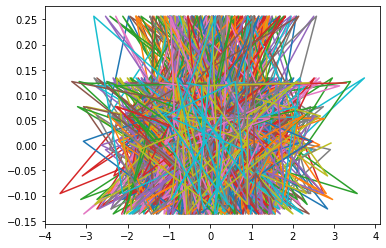

In [13]:
mxd2l.plt.plot(train_data[0],train_data[1]);

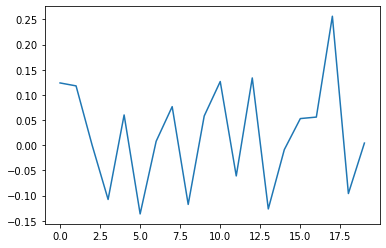

In [14]:
mxd2l.plt.plot(train_data[1]);

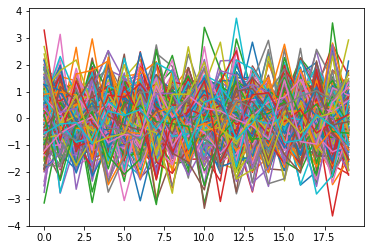

In [15]:
mxd2l.plt.plot(train_data[0]);

In [16]:
train_data[0].shape,train_data[0][0].shape

((20, 200), (200,))

In [17]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = mxnp.ones((num_inputs, 1)) * 0.01, 0.05
train_data = mxd2l.synthetic_data(true_w, true_b, n_train)
train_iter = mxd2l.load_array(train_data, batch_size)
test_data = mxd2l.synthetic_data(true_w, true_b, n_test)
test_iter = mxd2l.load_array(test_data, batch_size, is_train=False)

In [18]:
def init_params():
    w=mxnp.random.normal(scale=1,size=(num_inputs,1))
    print(f"w.shape={w.shape}")
    b=mxnp.zeros(1)
    w.attach_grad()
    b.attach_grad()
    return [w,b]

In [19]:
# init_params()

In [20]:
def l2_penalty(w):
    return (w**2).sum() / 2

In [27]:
def train(lambd):
    w,b=init_params()
    net=lambda X:mxd2l.linreg(X,w,b)
    loss=mxd2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator=mxd2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            with autograd.record():
                y_hat=net(X)
                l=loss(y_hat,y)+lambd*l2_penalty(w)
            l.backward()
            mxd2l.sgd([w,b],lr,batch_size)
        if (epoch+1) % 5==0:
            animator.add(epoch+1,(mxd2l.evaluate_loss(net, train_iter, loss),mxd2l.evaluate_loss(net, test_iter, loss)))
                       
    print('L2 norm of w:', mxnp.linalg.norm(w))                   

In [28]:
# mxnp.linalg??


L2 norm of w: 13.168718


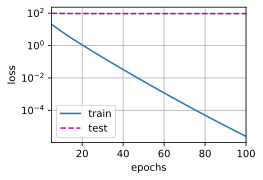

In [29]:
train(lambd=0)

L2 norm of w: 1.1982635


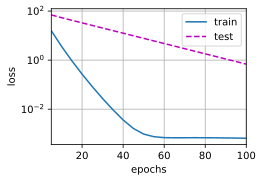

In [30]:
train(lambd=2)

L2 norm of w: 0.053528756


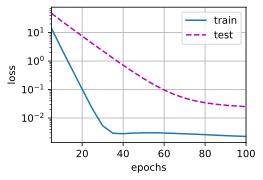

In [36]:
train(lambd=5)

L2 norm of w: 0.013901402


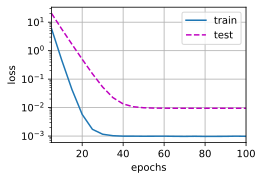

In [37]:
train(lambd=10)

## mxnet_gluon

In [36]:
def train_concise(wd):
    net=nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    loss=gluon.loss.L2Loss()
    num_epochs,lr=200,0.003
    trainer=gluon.Trainer(net.collect_params(),'sgd',optimizer_params={'learning_rate':lr,'wd':wd})
    # The bias parameter has not decayed. Bias names generally end with "bias"
    net.collect_params('.*bias').setattr('wd_mult', 0)
    print(f"net.collect_params('.*bias').get('wd_mult').wd_mult,{net.collect_params('.*bias').get('wd_mult').wd_mult}")
    
    animator = mxd2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',xlim=[5, num_epochs], legend=['train', 'valid'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            with autograd.record():
                l=loss(net(X),y)
            l.backward()
            trainer.step(batch_size)
        if (epoch + 1) % 5 == 0:
            train_loss=mxd2l.evaluate_loss(net, train_iter, loss)
            valid_loss=mxd2l.evaluate_loss(net, test_iter , loss)
            animator.add(epoch+1,(train_loss,valid_loss))
            
    print('L2 norm of w:', np.linalg.norm(net[0].weight.data()))

L2 norm of w: 13.628669


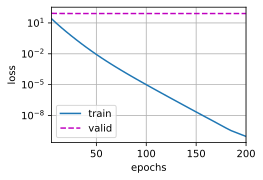

In [37]:
train_concise(0)

L2 norm of w: 0.013802616


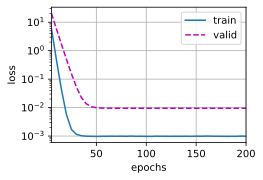

In [38]:
train_concise(10)

In [90]:
# gluon.Trainer??

In [34]:
net=nn.Sequential()
net.add(nn.Dense(1))
net.initialize(init.Normal(sigma=1))
net.collect_params()

sequential0_ (
  Parameter dense0_weight (shape=(1, -1), dtype=float32)
  Parameter dense0_bias (shape=(1,), dtype=float32)
)

In [35]:
net.collect_params('.*bias').setattr('wd_mult', 0)
print(f"net.collect_params('.*bias').get('wd_mult').wd_mult,{net.collect_params('.*bias').get('wd_mult').wd_mult}")

net.collect_params('.*bias').get('wd_mult').wd_mult,1.0


In [123]:
X,y=next(iter(train_iter))

In [124]:
yy=net(X)

In [126]:
net.collect_params().values

<bound method ParameterDict.values of sequential5_ (
  Parameter dense5_weight (shape=(1, 200), dtype=float32)
  Parameter dense5_bias (shape=(1,), dtype=float32)
)>

In [111]:
net.collect_params('.*bias')

sequential4_ (
  Parameter dense4_bias (shape=(1,), dtype=float32)
)

In [112]:
net.collect_params('.*weight')

sequential4_ (
  Parameter dense4_weight (shape=(1, 200), dtype=float32)
)

In [113]:
type(net.collect_params('.*bias'))

mxnet.gluon.parameter.ParameterDict

In [114]:
# gluon.parameter.ParameterDict??

In [136]:
type(pd.get('wd_mult'))

mxnet.gluon.parameter.Parameter

In [138]:
pd.get('wd_mult').wd_mult

1.0

In [127]:
pd.values()

odict_values([Parameter dense4_bias (shape=(1,), dtype=float32), Parameter sequential4_wd_mult (shape=None, dtype=<class 'numpy.float32'>)])

In [128]:
pd.wd_mult

AttributeError: 'ParameterDict' object has no attribute 'wd_mult'

In [129]:
net.collect_params('.*bias').setattr('wd_mult', 0)

In [130]:
net.collect_params('.*bias')

sequential5_ (
  Parameter dense5_bias (shape=(1,), dtype=float32)
)

## torch

In [39]:
import torch.nn as nn

In [40]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = tc.ones((num_inputs, 1)) * 0.01, 0.05
train_data = tcd2l.synthetic_data(true_w, true_b, n_train)
train_iter = tcd2l.load_array(train_data, batch_size)
test_data = tcd2l.synthetic_data(true_w, true_b, n_test)
test_iter = tcd2l.load_array(test_data, batch_size, is_train=False)

In [50]:
X,y=next(iter(train_iter))
X.shape,y.shape

(torch.Size([5, 200]), torch.Size([5, 1]))

In [42]:
len(test_iter),len(train_iter)

(20, 4)

In [43]:
def init_params():
    w=tc.normal(0,1,size=(num_inputs,1),requires_grad=True)
    b=tc.zeros(1,requires_grad=True)
    return [w,b]

In [45]:
w,b=init_params()

In [47]:
w.shape,b.shape

(torch.Size([200, 1]), torch.Size([1]))

In [49]:
w[0:10,0],b

(tensor([ 0.6324, -0.5304,  0.5004,  0.8125, -0.5999, -0.7236,  0.4215,  0.2891,
          1.9034,  0.1620], grad_fn=<SelectBackward>),
 tensor([0.], requires_grad=True))

In [51]:
y_hat=tcd2l.linreg(X,w,b)
y_hat.shape

torch.Size([5, 1])

In [59]:
loss=tcd2l.squared_loss

In [60]:
l=loss(y_hat,y)

In [63]:
l

tensor([[134.6416],
        [ 15.6898],
        [ 63.4503],
        [544.6068],
        [ 56.5562]], grad_fn=<DivBackward0>)

In [62]:
l+l2_penalty(w)

tensor([[230.6131],
        [111.6614],
        [159.4218],
        [640.5783],
        [152.5278]], grad_fn=<AddBackward0>)

In [44]:
def l2_penalty(w):
    return tc.sum(w.pow(2))/2

In [96]:
from functools import partial


In [97]:
net=partial(tcd2l.linreg,w=w,b=b)

In [98]:
net(X)

tensor([[ 16.5508],
        [ -5.3844],
        [ 11.1169],
        [-32.9407],
        [ 10.7477]], grad_fn=<AddBackward0>)

In [99]:
loss??

Signature: loss(y_hat, y)
Source:   
def squared_loss(y_hat, y):  #@save
    """Squared loss."""
    return (y_hat - d2l.reshape(y, y_hat.shape)) ** 2 / 2
File:      c:\users\hp\miniconda3\envs\d2l\lib\site-packages\d2l\torch.py
Type:      function


In [104]:
loss(net(X),y)

tensor([[134.6416],
        [ 15.6898],
        [ 63.4503],
        [544.6068],
        [ 56.5562]], grad_fn=<DivBackward0>)

In [100]:
l=loss(net(X),y)

In [107]:
def train(lambd):
    w,b=init_params()
    net=partial(tcd2l.linreg,w=w,b=b)
    loss=tcd2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = tcd2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            with tc.enable_grad():
                l=loss(net(X),y)
                l+=lambd*l2_penalty(w)
            l.sum().backward()
            tcd2l.sgd([w,b],lr,batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (tcd2l.evaluate_loss(net, train_iter, loss),
                                     tcd2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', tc.norm(w).item())

L2 norm of w: 0.027190331369638443


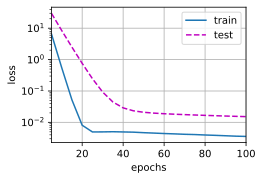

In [109]:
train(lambd=10)

### --concise

In [141]:
def train_concise(wd):
    net=nn.Sequential(nn.Linear(num_inputs,1))
    for p in net.parameters():
        print(p.shape)
        p.data.normal_()
#     net[0].bias.data=tc.zeros(1)
    print('L2 norm of w:', net[0].weight.norm().item(),net[0].bias.data)
    loss=nn.MSELoss()
    num_epochs, lr = 100, 0.003
    trainer=tc.optim.SGD([{"params":net[0].weight,"weight_decay":wd},
                          {"params":net[0].bias}],
                        lr=lr)
#     trainer = tc.optim.SGD([
#         {"params":net[0].weight,'weight_decay': wd},
#         {"params":net[0].bias}], lr=lr)
    animator = tcd2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tc.enable_grad():
                trainer.zero_grad()
                l = loss(net(X), y)
            l.backward()
            trainer.step()
#         if (epoch + 1) % 5 == 0:
#             animator.add(epoch + 1, (tcd2l.evaluate_loss(net, train_iter, loss),
#                                      tcd2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', net[0].weight.norm().item(),net[0].bias.data)

torch.Size([1, 200])
torch.Size([1])
L2 norm of w: 14.966571807861328 tensor([-0.3009])
L2 norm of w: 14.195639610290527 tensor([-0.2870])


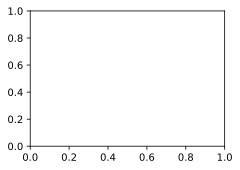

In [142]:
train_concise(0)

L2 norm of w: 0.030176766216754913


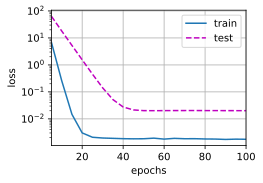

In [135]:
train_concise(10)

In [143]:
def train_concise(wd):
    net=nn.Sequential(nn.Linear(num_inputs,1))
    for p in net.parameters():
        print(p.shape)
        p.data.normal_()
    net[0].bias.data=tc.zeros(1)
    print('L2 norm of w:', net[0].weight.norm().item(),net[0].bias.data)
    loss=nn.MSELoss()
    num_epochs, lr = 100, 0.003
    trainer=tc.optim.SGD([{"params":net[0].weight,"weight_decay":wd},
                          {"params":net[0].bias}],
                        lr=lr)
#     trainer = tc.optim.SGD([
#         {"params":net[0].weight,'weight_decay': wd},
#         {"params":net[0].bias}], lr=lr)
    animator = tcd2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tc.enable_grad():
                trainer.zero_grad()
                l = loss(net(X), y)
            l.backward()
            trainer.step()
#         if (epoch + 1) % 5 == 0:
#             animator.add(epoch + 1, (tcd2l.evaluate_loss(net, train_iter, loss),
#                                      tcd2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', net[0].weight.norm().item(),net[0].bias.data)

torch.Size([1, 200])
torch.Size([1])
L2 norm of w: 13.980432510375977 tensor([0.])
L2 norm of w: 0.03119339793920517 tensor([0.0960])


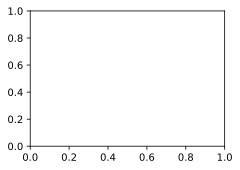

In [144]:
train_concise(10)

In [113]:
net=nn.Sequential(nn.Linear(num_inputs,1))
for p in net.parameters():
    print(p.shape)
#     p.data.normal_()

torch.Size([1, 200])
torch.Size([1])


In [114]:
net[0].bias

Parameter containing:
tensor([-0.0253], requires_grad=True)

## tensorflow

In [12]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = tf.ones((num_inputs, 1)) * 0.01, 0.05
train_data = tfd2l.synthetic_data(true_w, true_b, n_train)
train_iter = tfd2l.load_array(train_data, batch_size)
test_data = tfd2l.synthetic_data(true_w, true_b, n_test)
test_iter = tfd2l.load_array(test_data, batch_size, is_train=False)

In [147]:
X,y=next(iter(train_iter))
X.shape,y.shape

(TensorShape([5, 200]), TensorShape([5, 1]))

In [154]:
def init_params():
    w = tf.Variable(tf.random.normal(stddev=1, shape=(num_inputs, 1)))
    b = tf.Variable(tf.zeros(shape=(1, )))
    return [w, b]

In [155]:
w,b=init_params()

In [156]:
w.shape,b.shape

(TensorShape([200, 1]), TensorShape([1]))

In [157]:
w[0:3]

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.6467261],
       [1.122067 ],
       [0.7003606]], dtype=float32)>

In [158]:
b

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>

In [159]:
def l2_penalty(w):
    return tf.reduce_sum(tf.pow(w, 2)) / 2

In [162]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: tfd2l.linreg(X, w, b), tfd2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = tfd2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                # The L2 norm penalty term has been added, and broadcasting
                # makes `l2_penalty(w)` a vector whose length is `batch_size`
                l = loss(net(X), y) + lambd * l2_penalty(w)
            grads = tape.gradient(l, [w, b])
            tfd2l.sgd([w, b], grads, lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (tfd2l.evaluate_loss(net, train_iter, loss),
                                     tfd2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', tf.norm(w).numpy())

L2 norm of w: 0.028768925


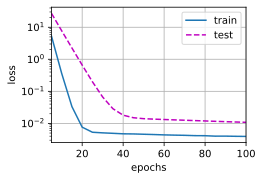

In [163]:
train(lambd=10)

In [164]:
tfd2l.sgd??

Signature: tfd2l.sgd(params, grads, lr, batch_size)
Source:   
def sgd(params, grads, lr, batch_size):  #@save
    """Minibatch stochastic gradient descent."""
    for param, grad in zip(params, grads):
        param.assign_sub(lr*grad/batch_size)
File:      c:\users\hp\miniconda3\envs\d2l\lib\site-packages\d2l\tensorflow.py
Type:      function


### --tfconcise

In [4]:
K=tf.keras

In [13]:
def train_concise(wd):
    net=K.models.Sequential()
    net.add(K.layers.Dense(1,kernel_regularizer=K.regularizers.l2(wd)))
    net.build(input_shape=(1,num_inputs))
    w,b=net.trainable_variables
    print(w.shape,b.shape)
    loss=K.losses.MeanSquaredError()
    num_epochs, lr = 100, 0.003
    trainer=K.optimizers.SGD(learning_rate=lr)
    animator = tfd2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            with tf.GradientTape() as tape:
                # tf.keras需要自己手动获取和添加层的losses，以进行定制化训练
                l=loss(net(X),y)+net.losses 
            grads=tape.gradient(l,[w,b])
            trainer.apply_gradients(zip(grads,[w,b]))
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (tfd2l.evaluate_loss(net, train_iter, loss),
                                     tfd2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', tf.norm(net.get_weights()[0]).numpy())
    

L2 norm of w: 1.3702968


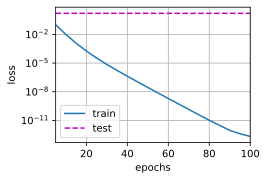

In [14]:
train_concise(0)

L2 norm of w: 0.025922392


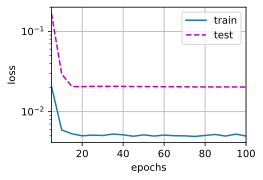

In [15]:
train_concise(10)

In [6]:
K.layers.Dense??

Init signature: K.layers.Dense(*args, **kwargs)
Source:        
class Dense(Layer):
  """Just your regular densely-connected NN layer.

  `Dense` implements the operation:
  `output = activation(dot(input, kernel) + bias)`
  where `activation` is the element-wise activation function
  passed as the `activation` argument, `kernel` is a weights matrix
  created by the layer, and `bias` is a bias vector created by the layer
  (only applicable if `use_bias` is `True`).

  Note: If the input to the layer has a rank greater than 2, then `Dense`
  computes the dot product between the `inputs` and the `kernel` along the
  last axis of the `inputs` and axis 1 of the `kernel` (using `tf.tensordot`).
  For example, if input has dimensions `(batch_size, d0, d1)`,
  then we create a `kernel` with shape `(d1, units)`, and the `kernel` operates
  along axis 2 of the `input`, on every sub-tensor of shape `(1, 1, d1)`
  (there are `batch_size * d0` such sub-tensors).
  The output in this case will have